In [2]:
import spectral as sp
import matplotlib.pyplot as plt
import numpy as np

In [ ]:
# Load the hyperspectral image using the hdr file
image_path = 'C:\TomatoSeedTomer\Tori_Seed_Unpolish_Infected_Tobamo_S2_Vnir__T12_2022-08-28_11-23-17\capture\Tori_Seed_Unpolish_Infected_Tobamo_S2_Vnir__T12_2022-08-28_11-23-17.hdr'  # Replace with your file path

img = sp.envi.open(image_path)
data = img.load()

print("Image shape (rows, columns, bands):", data.shape)
print("Wavelengths:", len(img.bands.centers))  # If wavelengths are available

c:\Users\sagig\AppData\Local\Programs\Python\Python310\lib\site-packages\spectral\io\envi.py:175: UserWarning: Parameters with non-lowercase names encountered and converted to lowercase. To retain source file parameter name capitalization, set spectral.settings.envi_support_nonlowercase_params to True.
  warnings.warn(msg)


Image shape (rows, columns, bands): (3000, 1600, 840)
Wavelengths: 840


In [6]:
band_index = 200
wavelength = img.bands.centers[band_index]
band = data[:,:,band_index]

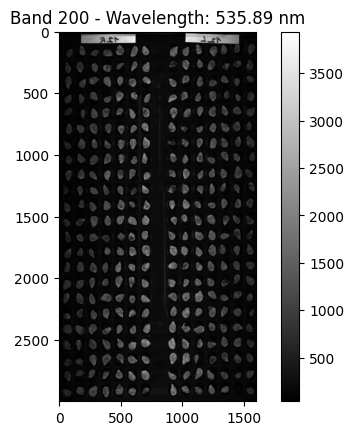

In [7]:
def display_band(b, band_index=band_index, wavelength=wavelength):
    plt.imshow(b, cmap='gray')
    plt.title(f'Band {band_index} - Wavelength: {wavelength} nm')
    plt.colorbar()
    plt.show()

display_band(band)

Find the end of the sticker using a threshold that the maximum value in sticker row should not be below of.

In [8]:
line_thickness = 3
line_value = 4000

In [9]:
def find_after_sticker_index():
    sticker_value_threshold = 3000
    is_end_of_sticker_found = False
    is_start_of_sticker_found = np.max(data[0,:,band_index]) > sticker_value_threshold
    after_sticker_index = 1

    while not is_end_of_sticker_found:
        is_row_sticker = np.max(data[after_sticker_index,:,band_index]) > sticker_value_threshold
        if not is_start_of_sticker_found and is_row_sticker:
            is_start_of_sticker_found = True
        elif is_start_of_sticker_found and not is_row_sticker:
            is_end_of_sticker_found = True
        after_sticker_index += 1
        
    return after_sticker_index

after_sticker_index = find_after_sticker_index()
print(after_sticker_index)

96


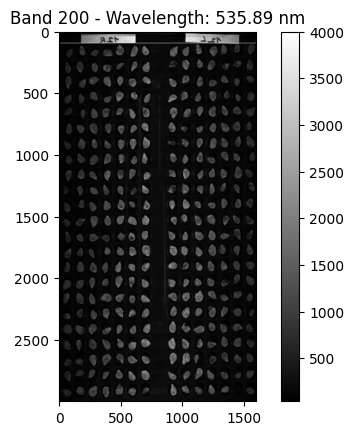

In [10]:
band_with_after_sticker_line = band.copy()
band_with_after_sticker_line[after_sticker_index:after_sticker_index+line_thickness,:,0] = line_value
display_band(band_with_after_sticker_line)

Find rows and columns using the momentum changes from an empty line to a seed line and vice versa.
A momentum change is set when the average pixel value in the row or the column passes a threshold for a couple of persistant bands.
After all the momentum changes are found the empty columns wrappers are averaged to get the separators between the rows and the columns.
The middle empty columns wrappers change like their paired seed wrapper.

In [11]:
# Helper function in debugging

def print_row(row_index):
    print(row_index, ': max=', np.max(data[row_index,:,band_index]))
    print(row_index, ': min=', np.min(data[row_index,:,band_index]))
    print(row_index, ': average=', np.average(data[row_index,:,band_index]))

def print_column(column_index):
    print(column_index, ': max=', np.max(data[after_sticker_index:,column_index,band_index]))
    print(column_index, ': min=', np.min(data[after_sticker_index:,column_index,band_index]))
    print(column_index, ': average=', np.average(data[after_sticker_index:,column_index,band_index]))

In [16]:
# Rows and columns can have differente average threshold value.
max_empty_row_avearage_value = 220
max_empty_column_avearage_value = 300

# Momentum is changed based on several lines in a row that keep the momentum to decrease the noise effect. The number of lines can change between rows and columns.
change_counter_row_threshold = 7
change_counter_column_threshold = 7


In [20]:
def find_row_momentum_changes(max_empty_row_avearage_value, change_counter_row_threshold):
    is_changed_to_empty_row = np.average(band[after_sticker_index,:]) > max_empty_row_avearage_value  # This tells if I changed from an empty row to a seed row
    change_counter = 0
    switch_momentum_row_indexes = [after_sticker_index]

    for i in range(after_sticker_index, data.shape[0] - 1):
        if is_changed_to_empty_row and np.average(band[i,:]) > max_empty_row_avearage_value:  # empty to seed
            if change_counter < change_counter_row_threshold:
                change_counter += 1
            else:
                is_changed_to_empty_row = False
                change_counter = 0
                switch_momentum_row_indexes.append(i-change_counter_row_threshold)
        if not is_changed_to_empty_row and np.average(band[i,:]) < max_empty_row_avearage_value:  # seed to empty
            if change_counter < change_counter_row_threshold:
                change_counter += 1
            else:
                is_changed_to_empty_row = True
                change_counter = 0
                switch_momentum_row_indexes.append(i-change_counter_row_threshold)

    switch_momentum_row_indexes.append(band.shape[0] - 1)

    return switch_momentum_row_indexes

momentum_row_changes_indexes = find_row_momentum_changes(max_empty_row_avearage_value, change_counter_row_threshold)
number_of_row_momentum_changes = len(momentum_row_changes_indexes)
print(momentum_row_changes_indexes)
print(number_of_row_momentum_changes)

[96, 112, 204, 242, 327, 368, 451, 494, 576, 616, 704, 745, 827, 868, 953, 991, 1076, 1119, 1203, 1245, 1324, 1368, 1450, 1494, 1576, 1622, 1702, 1739, 1825, 1872, 1955, 1994, 2081, 2114, 2207, 2241, 2329, 2371, 2455, 2495, 2581, 2612, 2703, 2749, 2829, 2879, 2961, 2999]
48


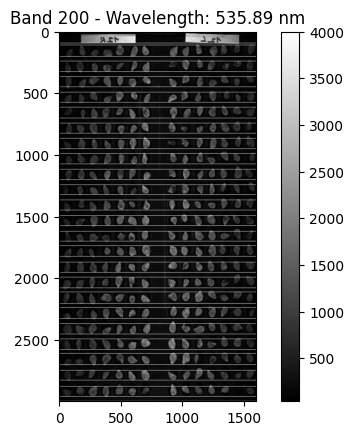

In [ ]:
band_with_row_changes = band.copy()
for i in range(number_of_row_momentum_changes):
    row = momentum_row_changes_indexes[i]
    band_with_row_changes[row:row+line_thickness,:,0] = line_value

display_band(band_with_row_changes)

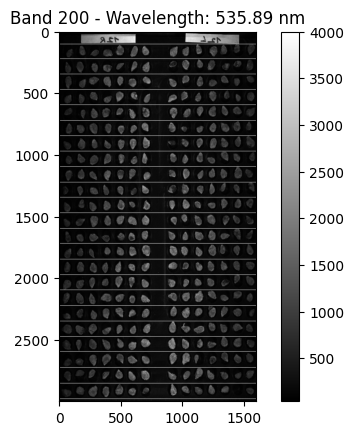

[104, 223, 347, 472, 596, 724, 847, 972, 1097, 1224, 1346, 1472, 1599, 1720, 1848, 1974, 2097, 2224, 2350, 2475, 2596, 2726, 2854, 2980]


In [ ]:
def find_average_rows_indexes():
    average_rows_indexes = []
    for i in range(0, number_of_row_momentum_changes, 2):
        row = (momentum_row_changes_indexes[i] + momentum_row_changes_indexes[i+1])//2
        average_rows_indexes.append(row)

    return average_rows_indexes

average_rows_indexes = find_average_rows_indexes()

band_with_average_rows = band.copy()
for row in average_rows_indexes:
    band_with_average_rows[row:row+line_thickness,:,0] = line_value

display_band(band_with_average_rows)
print(average_rows_indexes)

In [27]:
def find_momentum_column_changes(max_empty_column_avearage_value, change_counter_column_threshold):
    is_changed_to_empty_column = np.average(data[0,:,band_index]) < max_empty_column_avearage_value  # This tells if I changed from an empty row to a seed row
    change_counter = 0
    switch_momentum_column_indexes = [0]

    for i in range(1, data.shape[1]-1):
        if is_changed_to_empty_column and np.average(data[after_sticker_index:,i,band_index]) > max_empty_column_avearage_value:  # empty to seed
            if change_counter < change_counter_column_threshold:
                change_counter += 1
            else:
                is_changed_to_empty_column = False
                change_counter = 0
                switch_momentum_column_indexes.append(i-change_counter_column_threshold)
        if not is_changed_to_empty_column and np.average(data[after_sticker_index:,i,band_index]) < max_empty_column_avearage_value:  # seed to empty
            if change_counter < change_counter_column_threshold:
                change_counter += 1
            else:
                is_changed_to_empty_column = True
                change_counter = 0
                switch_momentum_column_indexes.append(i-change_counter_column_threshold)

    switch_momentum_column_indexes.append(data.shape[1] - 1)

    return switch_momentum_column_indexes

momentum_column_changes_indexes = find_momentum_column_changes(max_empty_column_avearage_value, change_counter_column_threshold)
number_of_column_momentum_changes = len(momentum_column_changes_indexes)
print(momentum_column_changes_indexes)
print(number_of_column_momentum_changes)

[0, 58, 88, 153, 197, 250, 306, 358, 417, 465, 523, 565, 626, 667, 735, 882, 951, 994, 1053, 1100, 1162, 1206, 1265, 1310, 1363, 1416, 1464, 1522, 1565, 1599]
30


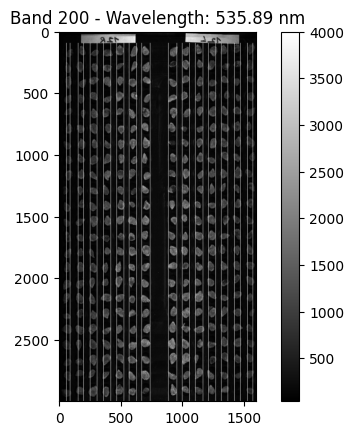

In [28]:
band_with_column_change_lines = band.copy()
for i in range(0, number_of_column_momentum_changes):
    column = momentum_column_changes_indexes[i]
    band_with_column_change_lines[after_sticker_index:,column:column+line_thickness,0] = line_value

display_band(band_with_column_change_lines, band_index, wavelength)

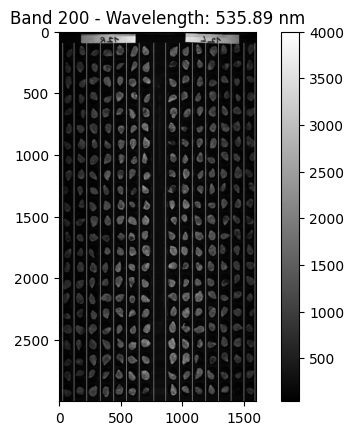

[29, 120, 223, 332, 441, 544, 646, 765, 861, 972, 1076, 1184, 1287, 1389, 1493, 1582]


In [37]:
def find_average_columns_indexes():
    average_column_indexes = []

    # Find average columns until the middle, change the middle like its paired seed warpper column, and average after the middle.

    i = 0
    for i in range(0, number_of_column_momentum_changes//2 - 1, 2):
        column = (momentum_column_changes_indexes[i] + momentum_column_changes_indexes[i+1])//2
        average_column_indexes.append(column)

    column = momentum_column_changes_indexes[i+2] + (momentum_column_changes_indexes[i] - momentum_column_changes_indexes[i-1])//2
    average_column_indexes.append(column)
    column = momentum_column_changes_indexes[i+3] - (momentum_column_changes_indexes[i+5] - momentum_column_changes_indexes[i+4])//2
    average_column_indexes.append(column)

    for i in range(i + 4, number_of_column_momentum_changes, 2):
        column = (momentum_column_changes_indexes[i] + momentum_column_changes_indexes[i+1])//2
        average_column_indexes.append(column)

    return average_column_indexes

average_column_indexes = find_average_columns_indexes()

band_with_average_columns = band.copy()
for column in average_column_indexes:
    band_with_average_columns[after_sticker_index:,column:column+line_thickness,0] = line_value

display_band(band_with_average_columns)
print(average_column_indexes)

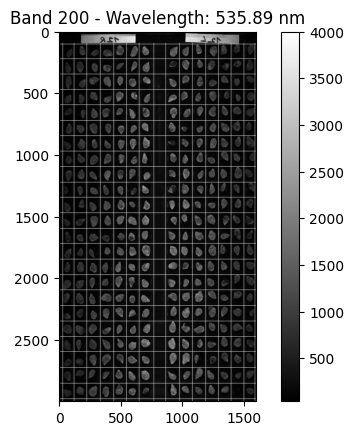

In [38]:
band_with_average_rows_and_columns = band.copy()

for row in average_rows_indexes:
    band_with_average_rows_and_columns[row:row+line_thickness,:,0] = line_value

for column in average_column_indexes:
    band_with_average_rows_and_columns[after_sticker_index:,column:column+line_thickness,0] = line_value

display_band(band_with_average_rows_and_columns)

Extract separated seeds indexes.

In [60]:
def extract_separated_images_points():
    separated_images_points = []

    for row in range(len(average_rows_indexes) - 1):
        for column in range(1, len(average_column_indexes) - 1):
            separated_images_points.append(((average_rows_indexes[row], average_column_indexes[column]), (average_rows_indexes[row + 1], average_column_indexes[column + 1])))

    return np.array(separated_images_points)

separated_images_points = extract_separated_images_points()
np.save(image_path.split('\\')[2] + f'_sparation.npy', separated_images_points)

print(average_rows_indexes)
print(len(average_rows_indexes) - 1)
print(average_column_indexes)
print(len(average_column_indexes) - 2)
print(separated_images_points)
print(len(separated_images_points))

[104, 223, 347, 472, 596, 724, 847, 972, 1097, 1224, 1346, 1472, 1599, 1720, 1848, 1974, 2097, 2224, 2350, 2475, 2596, 2726, 2854, 2980]
23
[29, 120, 223, 332, 441, 544, 646, 765, 861, 972, 1076, 1184, 1287, 1389, 1493, 1582]
14
[[[ 104  120]
  [ 223  223]]

 [[ 104  223]
  [ 223  332]]

 [[ 104  332]
  [ 223  441]]

 ...

 [[2854 1287]
  [2980 1389]]

 [[2854 1389]
  [2980 1493]]

 [[2854 1493]
  [2980 1582]]]
322


In [61]:
seed_number = 200
seed_name = image_path.split('\\')[2] + f'_seed_{seed_number}.npy'
single_seed_image_points = separated_images_points[seed_number]
single_seed_image = band[single_seed_image_points[0][0]:single_seed_image_points[1][0],single_seed_image_points[0][1]:single_seed_image_points[1][1]]
np.save(seed_name, single_seed_image)

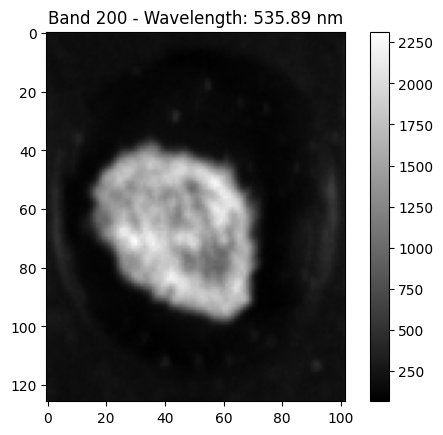

In [54]:
display_band(np.load(seed_name))